### we will visualise the performance and plots on the tuned model(CNN_TF_Tuned)

In [ ]:
# IMPORT NECESSARY LIBRARIES
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.manifold import TSNE
from tensorflow.keras.layers import LeakyReLU

In [ ]:
# LOAD TRAINED MODEL & TEST DATA
model_path = "../5ADVANCED_TRAINING/Tuned_Model/CNN_TF_Tuned.keras"
history_path = model_path.replace(".keras", "_history.npy")
test_csv_path = "../2PREPROCESSING/Processed_CSV/cropped_test.csv"

# Load trained model with custom activation function
model = tf.keras.models.load_model(model_path, custom_objects={"LeakyReLU": LeakyReLU})
print(f"Loaded Model: {model_path}")

# Load training history
history = np.load(history_path, allow_pickle=True).item()

# Load test data
test_data = np.loadtxt(test_csv_path, delimiter=",", skiprows=1)
X_test = test_data[:, 1:].reshape(-1, 20, 20, 1) / 255.0  # Normalize
y_test = test_data[:, 0].astype(int)
print(f"Test Data Shape: {X_test.shape}, Labels: {y_test.shape}")

# Predict probabilities & classes
y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)
print("Predictions complete!")

Loaded Model: ../5ADVANCED_TRAINING/Tuned_Model/CNN_TF_Tuned.keras
Test Data Shape: (10000, 20, 20, 1), Labels: (10000,)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predictions complete!


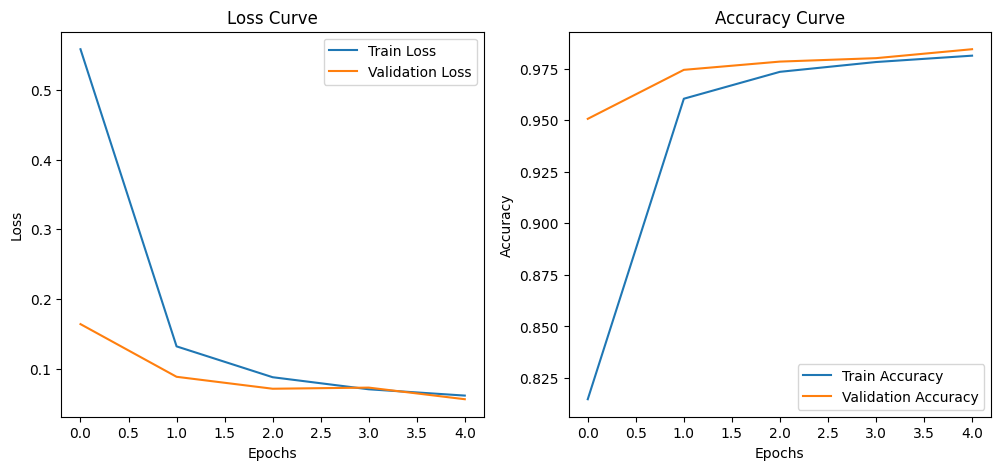

In [5]:
# =====================================================
# 1. PLOT LOSS & ACCURACY CURVES
# =====================================================
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

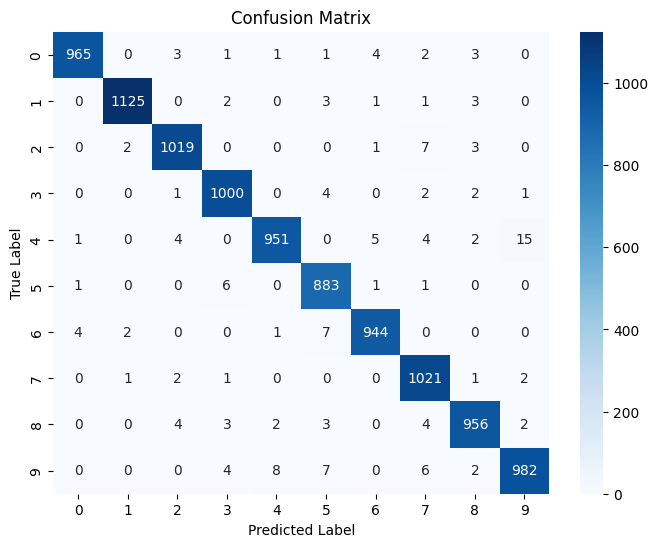

In [6]:
# =====================================================
# 2. CONFUSION MATRIX
# =====================================================
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [7]:
# =====================================================
# 3. CLASSIFICATION REPORT
# =====================================================
class_report = classification_report(y_test, y_pred, target_names=[str(i) for i in range(10)])
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.97      0.98       982
           5       0.97      0.99      0.98       892
           6       0.99      0.99      0.99       958
           7       0.97      0.99      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



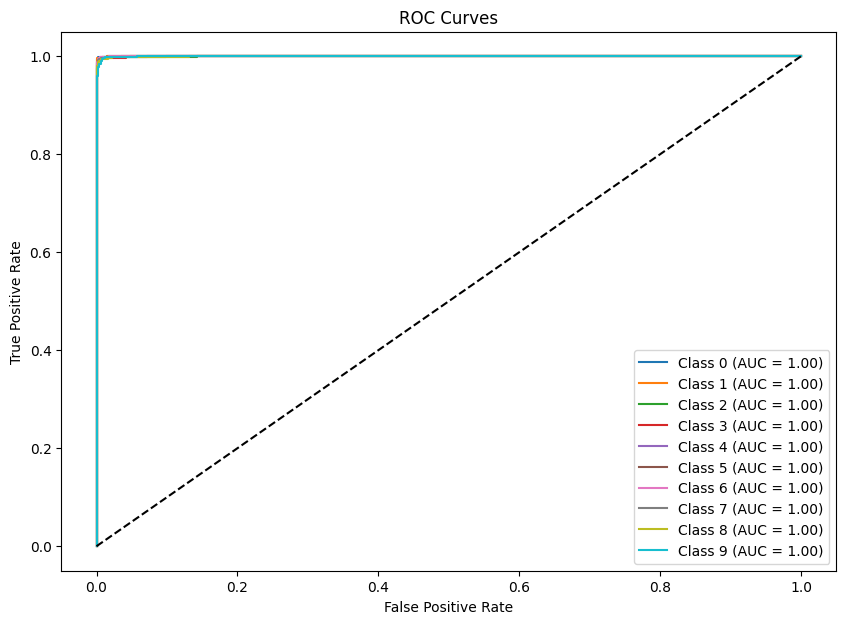

In [8]:
# =====================================================
# 4. ROC CURVES
# =====================================================
plt.figure(figsize=(10, 7))
for i in range(10):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

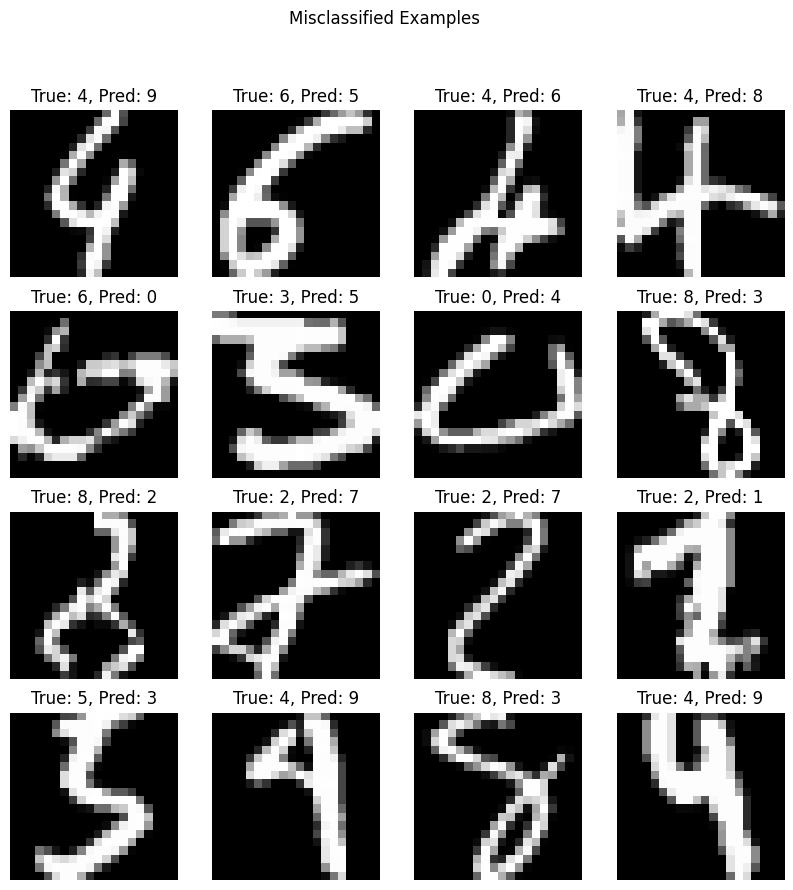

In [9]:
# =====================================================
# 5. MISCLASSIFIED EXAMPLES
# =====================================================
misclassified_idxs = np.where(y_test != y_pred)[0]

plt.figure(figsize=(10, 10))
for i, idx in enumerate(misclassified_idxs[:16]):  # Show first 16 misclassified
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_test[idx].squeeze(), cmap="gray")
    plt.title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}")
    plt.axis("off")

plt.suptitle("Misclassified Examples")
plt.show()

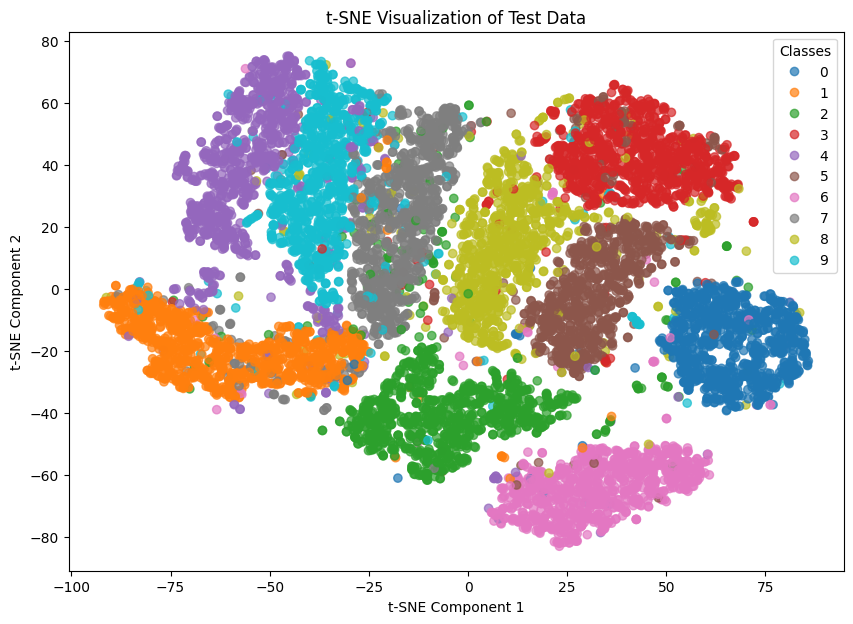

In [10]:
# =====================================================
# 6. t-SNE VISUALIZATION
# =====================================================
X_flat = X_test.reshape(X_test.shape[0], -1)  # Flatten images for t-SNE
X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_flat)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test, cmap="tab10", alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of Test Data")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


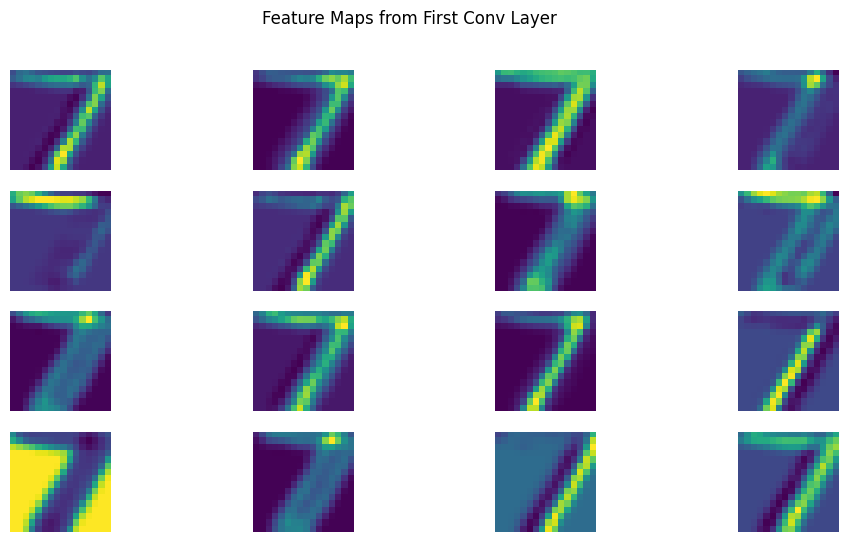

In [14]:
# =====================================================
# 7. FILTER VISUALIZATION (FIRST CONV LAYER)
# =====================================================

# Ensure model has an input by running a forward pass
_ = model.predict(np.expand_dims(X_test[0], axis=0))

# Extract convolutional layer outputs
layer_outputs = [layer.output for layer in model.layers if "conv2d" in layer.name]
feature_extractor = tf.keras.models.Model(inputs=model.layers[0].input, outputs=layer_outputs)

# Get feature maps
sample_img = np.expand_dims(X_test[0], axis=0)  # Use first test image
feature_maps = feature_extractor.predict(sample_img)

# Plot first Conv layer feature maps
layer_1_maps = feature_maps[0][0]  # First Conv layer
num_filters = layer_1_maps.shape[-1]

plt.figure(figsize=(12, 6))
for i in range(min(num_filters, 16)):  # Show first 16 feature maps
    plt.subplot(4, 4, i + 1)
    plt.imshow(layer_1_maps[:, :, i], cmap="viridis")
    plt.axis("off")

plt.suptitle("Feature Maps from First Conv Layer")
plt.show()

## We conclude that model performs well on the test set with minimum missclassification
